# Model 1: CNN Model

This model establishes baseline performance using:
* Conv2D filters=256, kernel_size=7, activation=relu
* Maxpooling with 5x5 poolsize
* Conv2D filters=64, kernel_size=5, activation=relu
* Maxpooling with 3x3 poolsize
* Conv2D filters=32, kernel_size=7, activation=relu
* Maxpooling with 3x3 poolsize

466883 params

In [26]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

np.random.seed(1)
tf.random.set_seed(1)
warnings.filterwarnings('ignore')

In [27]:
# Initial retrival
classes = {'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
def get_data(path):
    generator = ImageDataGenerator(rescale=1.0/255.)
    dataset = generator.flow_from_directory(
        directory=path,
        target_size=IMG_SHAPE,
        color_mode='rgb',
        class_mode='sparse',
        classes=classes,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )
    return dataset

In [28]:
# Image generator params

TRAIN_PATH = "covid19-resources/train"
TEST_PATH = "covid19-resources/test"
IMG_SHAPE = [224, 224]
BATCH_SIZE = 32

In [29]:
training_data = get_data(TRAIN_PATH)

Found 251 images belonging to 3 classes.


In [30]:
# Preview images
def preview_data(data):
    features = data[0][0]
    labels = data[0][1]
    fig, ax = plt.subplots(figsize=(20,20), ncols=4, nrows=4)
    for i, a in enumerate(ax.flatten()):
        a.imshow(features[i])
        a.set_title("Normal" if labels[i] == 0 else "Viral Pneumonia" if labels[i] == 1 else "Covid")
    fig.suptitle("")

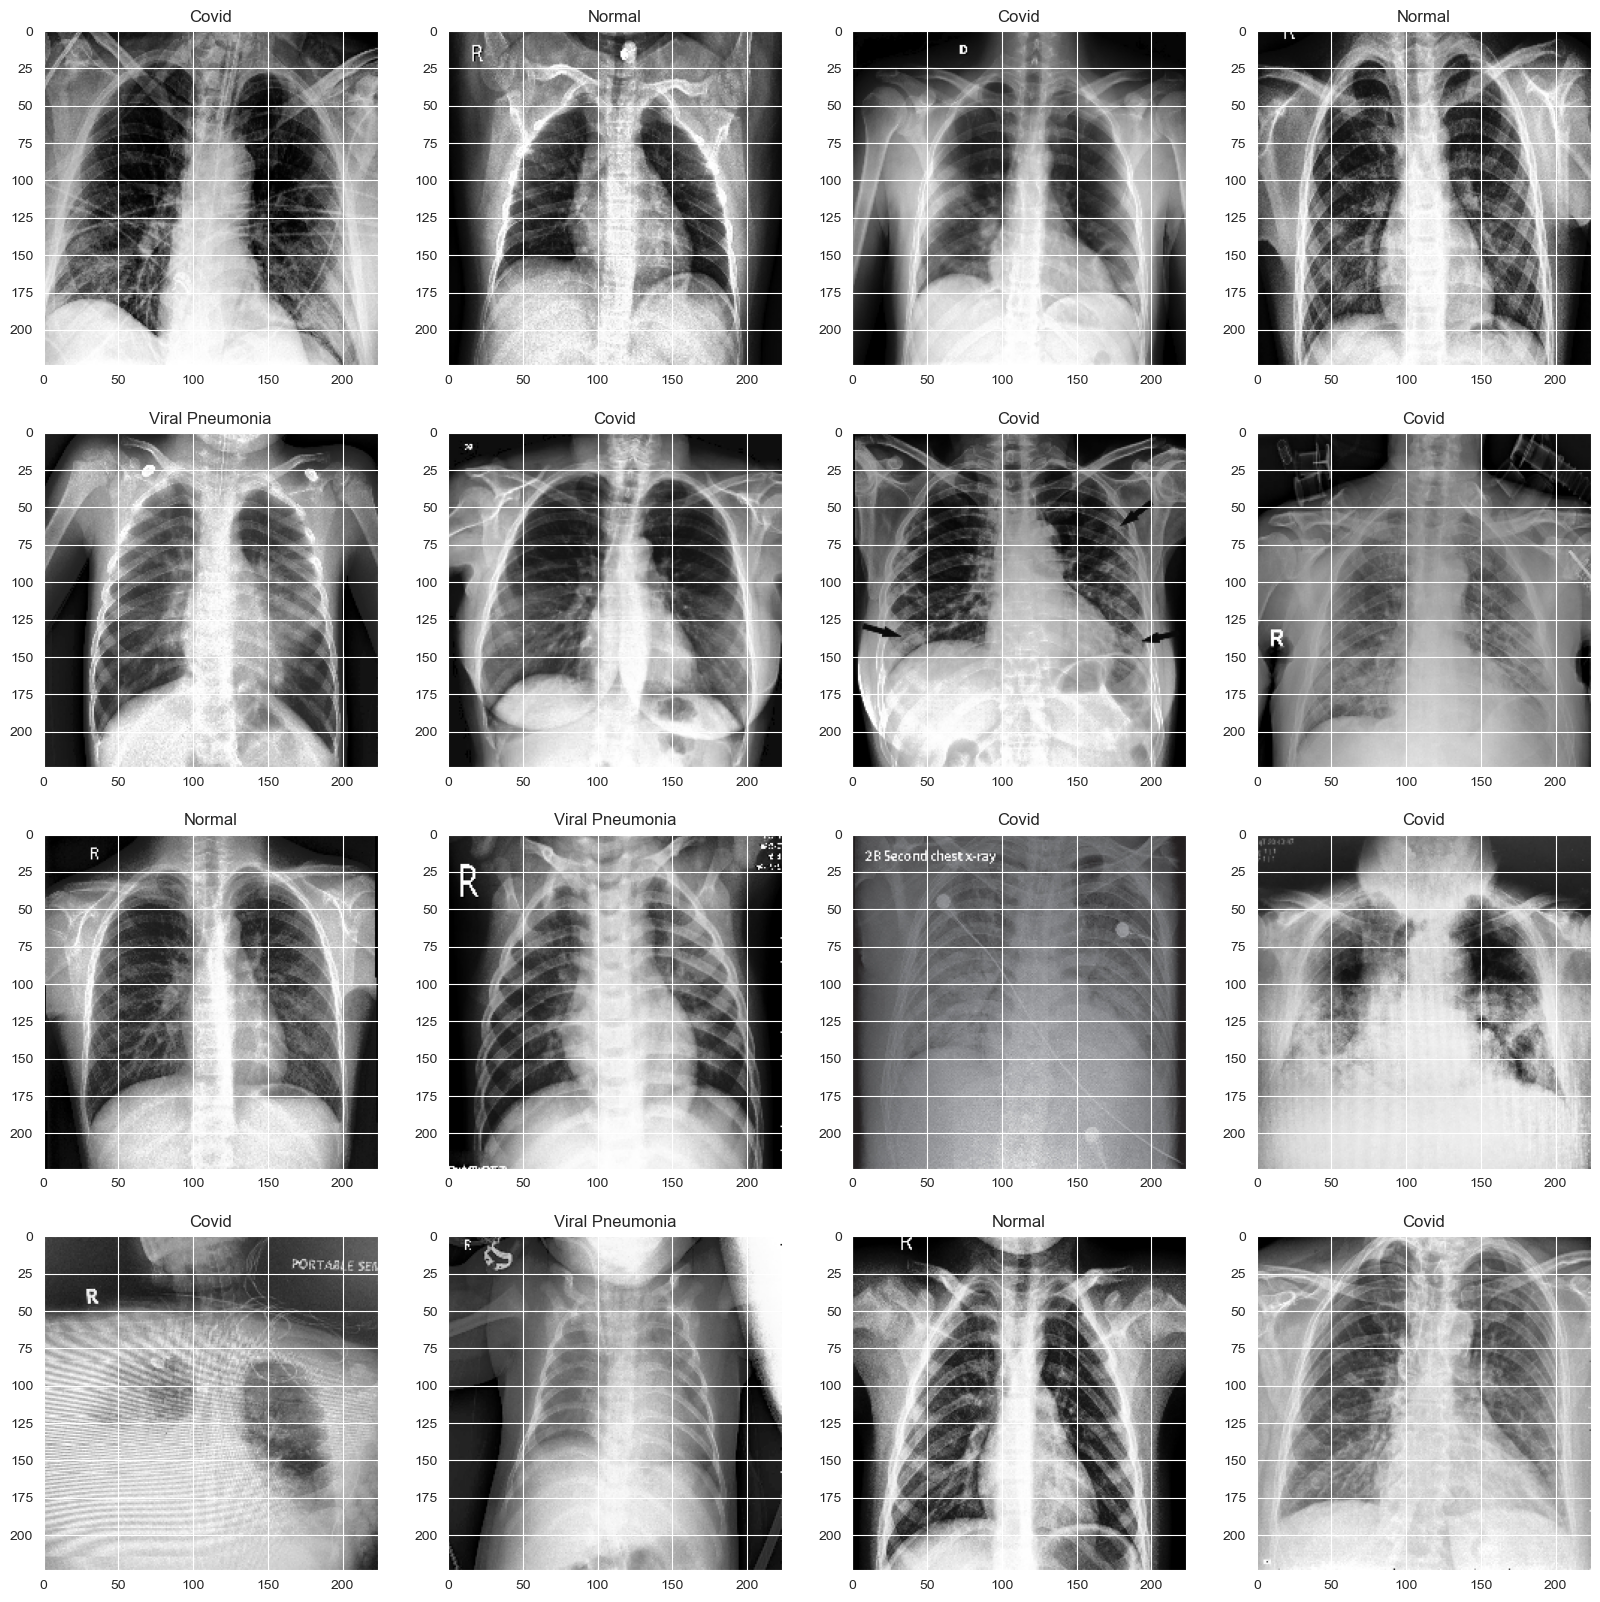

In [31]:
preview_data(training_data)

In [32]:
# Augment data to accommodate body angles, body size, etc.
def get_augmented_data(path):
    generator = ImageDataGenerator(rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
    )
    dataset = generator.flow_from_directory(
        directory=path,
        target_size=IMG_SHAPE,
        color_mode='rgb',
        class_mode='sparse',
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )
    return dataset

In [33]:
training_data = get_augmented_data(TRAIN_PATH)
testing_data = get_augmented_data(TEST_PATH)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


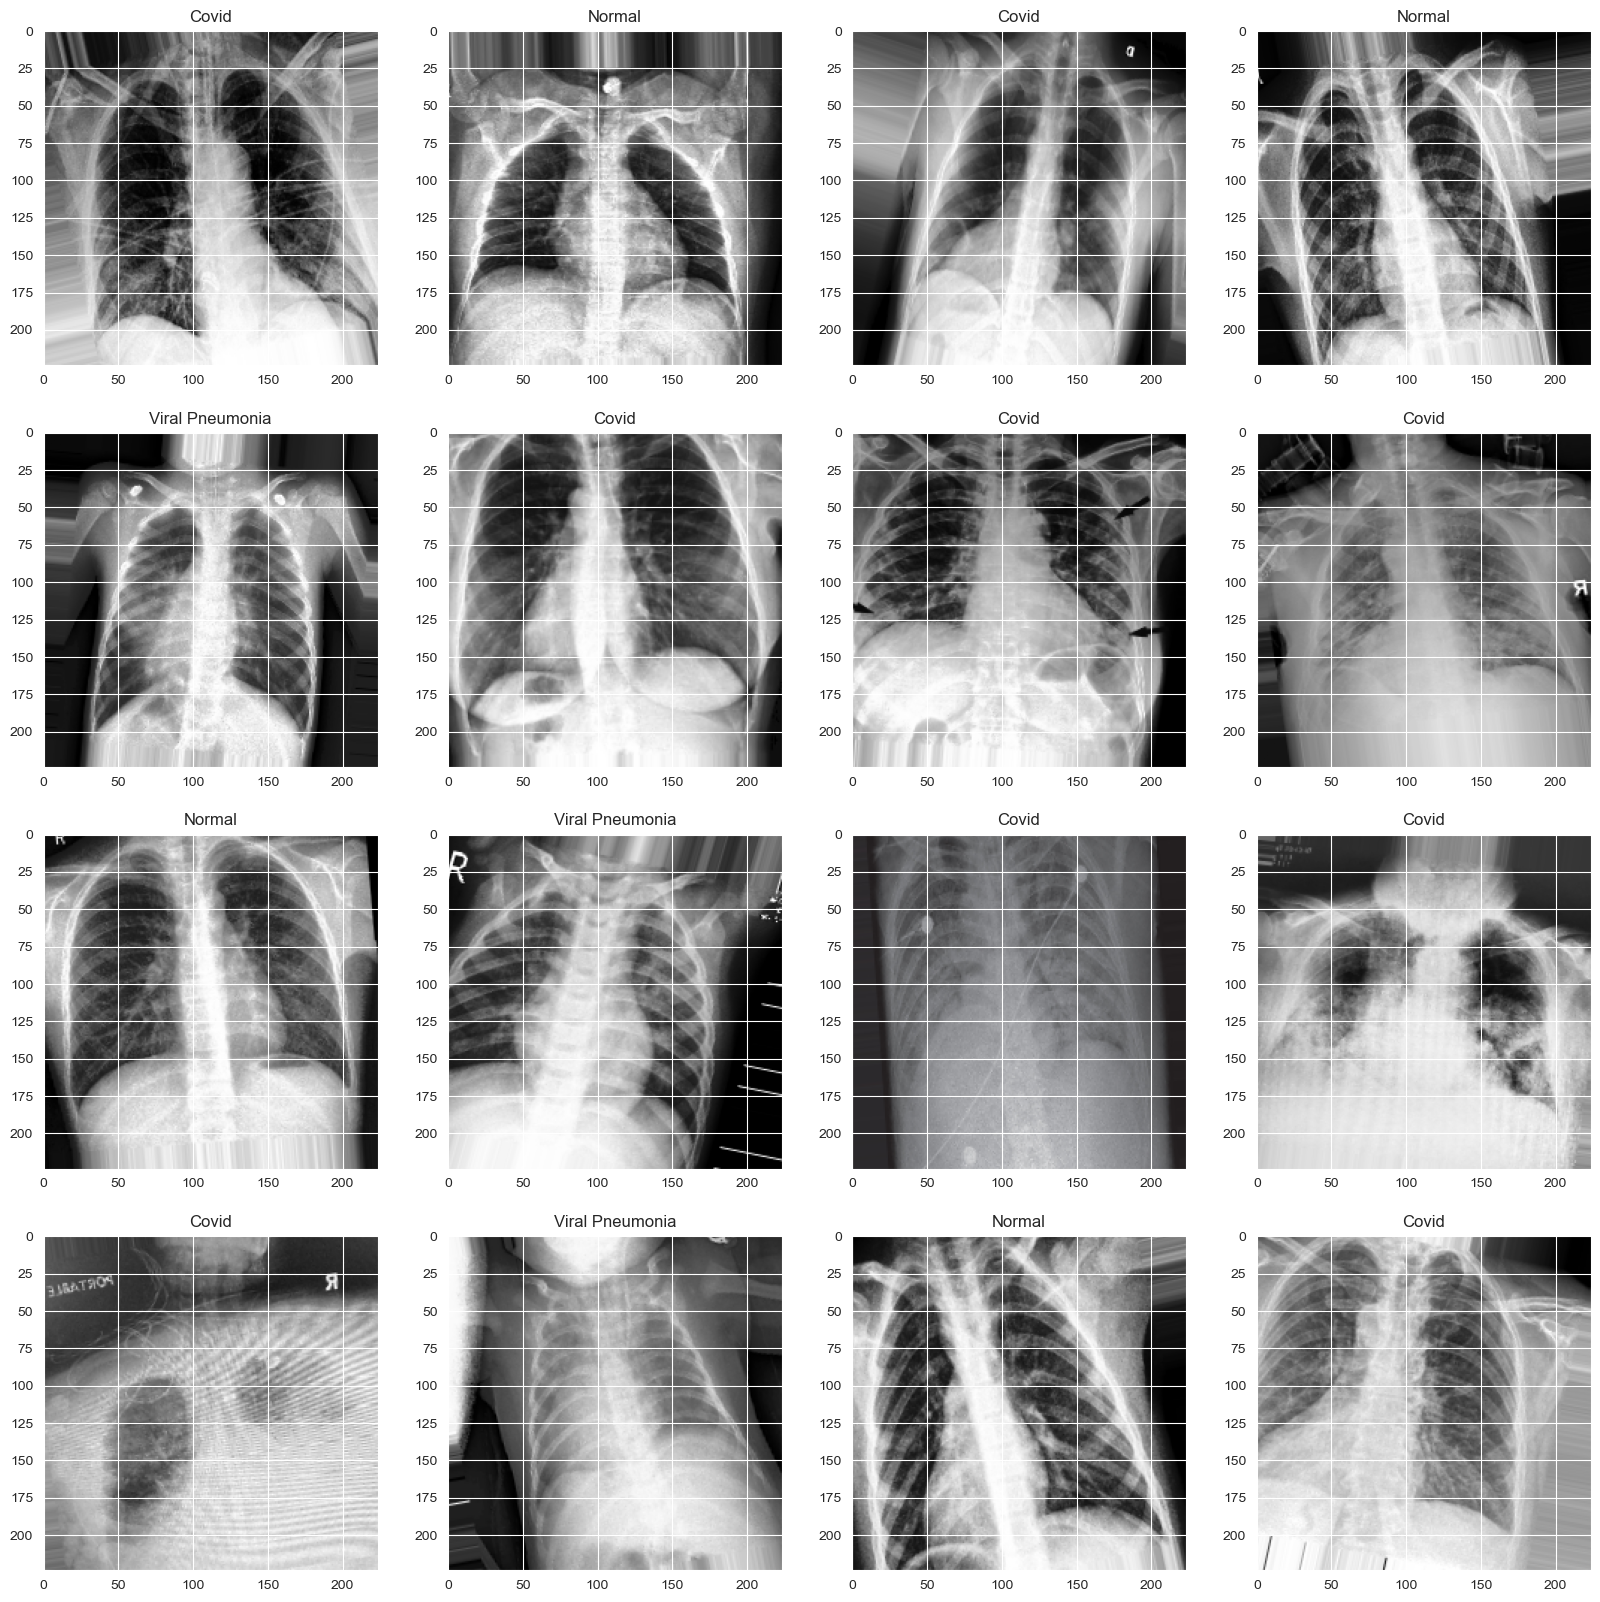

In [34]:
preview_data(training_data)

In [58]:
# Build model
# class AccuracyCallback(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('accuracy') > 0.95:
#             self.model.stop_training = True

cp_callback = ModelCheckpoint('models/m1_best_cnn', 
                             monitor='accuracy', 
                             verbose=1, 
                             mode='max',
                             save_best_only=True)

es_callback = EarlyStopping(monitor="val_loss", 
                      mode="min",
                      restore_best_weights=True, 
                      patience=10)

def build_model_one():
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
    model.add(tf.keras.layers.Conv2D(256, 7, strides=1, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5)))
    model.add(tf.keras.layers.Conv2D(64, 3, strides=1, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(3,activation="softmax"))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def fit_model(md, x_train, x_valid, e):
    history = md.fit(x_train, validation_data=x_valid, epochs=e, callbacks=[cp_callback, es_callback])
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc='best')
    ax[1].plot(history.history['loss'], label='training_loss')
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(loc='best')
    fig.suptitle('CNN')
    fig.savefig('Images/model-performance/model1_cnn.png')
    return history

In [59]:
# Model Summary
model = build_model_one()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 256)     37888     
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 43, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 64)        147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 3)                 3

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.4183
Epoch 1: accuracy improved from -inf to 0.41833, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 1.0988 - accuracy: 0.4183 - val_loss: 1.0396 - val_accuracy: 0.4394
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.9491 - accuracy: 0.5498
Epoch 2: accuracy improved from 0.41833 to 0.54980, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.9491 - accuracy: 0.5498 - val_loss: 0.8318 - val_accuracy: 0.6515
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7131
Epoch 3: accuracy improved from 0.54980 to 0.71315, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.6807 - accuracy: 0.7131 - val_loss: 0.9135 - val_accuracy: 0.6515
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.7689
Epoch 4: accuracy improved from 0.71315 to 0.76892, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.5701 - accuracy: 0.7689 - val_loss: 0.7655 - val_accuracy: 0.7121
Epoch 5/50
8/8 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7012
Epoch 5: accuracy did not improve from 0.76892
8/8 [==============================] - 15s 2s/step - loss: 0.6726 - accuracy: 0.7012 - val_loss: 0.7138 - val_accuracy: 0.6212
Epoch 6/50
8/8 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7610
Epoch 6: accuracy did not improve from 0.76892
8/8 [==============================] - 15s 2s/step - loss: 0.5650 - accuracy: 0.7610 - val_loss: 0.7898 - val_accuracy: 0.6515
Epoch 7/50
8/8 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.8287
Epoch 7: accuracy improved from 0.76892 to 0.82869, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 15s 2s/step - loss: 0.4531 - accuracy: 0.8287 - val_loss: 0.6900 - val_accuracy: 0.7121
Epoch 8/50
8/8 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8367
Epoch 8: accuracy improved from 0.82869 to 0.83665, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.4487 - accuracy: 0.8367 - val_loss: 1.1543 - val_accuracy: 0.6212
Epoch 9/50
8/8 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.8127
Epoch 9: accuracy did not improve from 0.83665
8/8 [==============================] - 15s 2s/step - loss: 0.5245 - accuracy: 0.8127 - val_loss: 0.8637 - val_accuracy: 0.5758
Epoch 10/50
8/8 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.7888
Epoch 10: accuracy did not improve from 0.83665
8/8 [==============================] - 15s 2s/step - loss: 0.4873 - accuracy: 0.7888 - val_loss: 0.6114 - val_accuracy: 0.7576
Epoch 11/50
8/8 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8606
Epoch 11: accuracy improved from 0.83665 to 0.86056, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 15s 2s/step - loss: 0.3880 - accuracy: 0.8606 - val_loss: 0.8749 - val_accuracy: 0.6364
Epoch 12/50
8/8 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8406
Epoch 12: accuracy did not improve from 0.86056
8/8 [==============================] - 15s 2s/step - loss: 0.4018 - accuracy: 0.8406 - val_loss: 0.6322 - val_accuracy: 0.7424
Epoch 13/50
8/8 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8327
Epoch 13: accuracy did not improve from 0.86056
8/8 [==============================] - 15s 2s/step - loss: 0.4192 - accuracy: 0.8327 - val_loss: 0.6143 - val_accuracy: 0.7121
Epoch 14/50
8/8 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.8048
Epoch 14: accuracy did not improve from 0.86056
8/8 [==============================] - 15s 2s/step - loss: 0.4799 - accuracy: 0.8048 - val_loss: 0.5198 - val_accuracy: 0.7424
Epoch 15/50
8/8 [==============================] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.3746 - accuracy: 0.8964 - val_loss: 0.5474 - val_accuracy: 0.7576
Epoch 20/50
8/8 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8685
Epoch 20: accuracy did not improve from 0.89641
8/8 [==============================] - 15s 2s/step - loss: 0.3852 - accuracy: 0.8685 - val_loss: 0.6068 - val_accuracy: 0.7879
Epoch 21/50
8/8 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8805
Epoch 21: accuracy did not improve from 0.89641
8/8 [==============================] - 15s 2s/step - loss: 0.3414 - accuracy: 0.8805 - val_loss: 0.5761 - val_accuracy: 0.7576
Epoch 22/50
8/8 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8367
Epoch 22: accuracy did not improve from 0.89641
8/8 [==============================] - 15s 2s/step - loss: 0.3670 - accuracy: 0.8367 - val_loss: 0.5675 - val_accuracy: 0.8030
Epoch 23/50
8/8 [==============================] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 15s 2s/step - loss: 0.3017 - accuracy: 0.9044 - val_loss: 0.4806 - val_accuracy: 0.7879
Epoch 25/50
8/8 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.8924
Epoch 25: accuracy did not improve from 0.90438
8/8 [==============================] - 15s 2s/step - loss: 0.3017 - accuracy: 0.8924 - val_loss: 0.3103 - val_accuracy: 0.8788
Epoch 26/50
8/8 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9004
Epoch 26: accuracy did not improve from 0.90438
8/8 [==============================] - 15s 2s/step - loss: 0.2753 - accuracy: 0.9004 - val_loss: 0.9202 - val_accuracy: 0.7424
Epoch 27/50
8/8 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8287
Epoch 27: accuracy did not improve from 0.90438
8/8 [==============================] - 15s 2s/step - loss: 0.4288 - accuracy: 0.8287 - val_loss: 0.3618 - val_accuracy: 0.8939
Epoch 28/50
8/8 [==============================] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.2538 - accuracy: 0.9203 - val_loss: 0.3056 - val_accuracy: 0.8636
Epoch 34/50
8/8 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.9203
Epoch 34: accuracy did not improve from 0.92032
8/8 [==============================] - 15s 2s/step - loss: 0.2313 - accuracy: 0.9203 - val_loss: 0.6648 - val_accuracy: 0.8485
Epoch 35/50
8/8 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.9163
Epoch 35: accuracy did not improve from 0.92032
8/8 [==============================] - 15s 2s/step - loss: 0.2406 - accuracy: 0.9163 - val_loss: 0.4723 - val_accuracy: 0.8182
Epoch 36/50
8/8 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.8725
Epoch 36: accuracy did not improve from 0.92032
8/8 [==============================] - 15s 2s/step - loss: 0.2725 - accuracy: 0.8725 - val_loss: 0.3690 - val_accuracy: 0.8788
Epoch 37/50
8/8 [==============================] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.2472 - accuracy: 0.9243 - val_loss: 0.4671 - val_accuracy: 0.8485
Epoch 39/50
8/8 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9323
Epoch 39: accuracy improved from 0.92430 to 0.93227, saving model to models/m1_best_cnn
INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


INFO:tensorflow:Assets written to: models/m1_best_cnn/assets


8/8 [==============================] - 16s 2s/step - loss: 0.2593 - accuracy: 0.9323 - val_loss: 0.1845 - val_accuracy: 0.9394
Epoch 40/50
8/8 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9243
Epoch 40: accuracy did not improve from 0.93227
8/8 [==============================] - 15s 2s/step - loss: 0.2433 - accuracy: 0.9243 - val_loss: 0.3718 - val_accuracy: 0.9242
Epoch 41/50
8/8 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.9044
Epoch 41: accuracy did not improve from 0.93227
8/8 [==============================] - 15s 2s/step - loss: 0.3013 - accuracy: 0.9044 - val_loss: 0.5068 - val_accuracy: 0.8030
Epoch 42/50
8/8 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8924
Epoch 42: accuracy did not improve from 0.93227
8/8 [==============================] - 15s 2s/step - loss: 0.3127 - accuracy: 0.8924 - val_loss: 0.2851 - val_accuracy: 0.9091
Epoch 43/50
8/8 [==============================] - ETA: 0s - loss: 0.

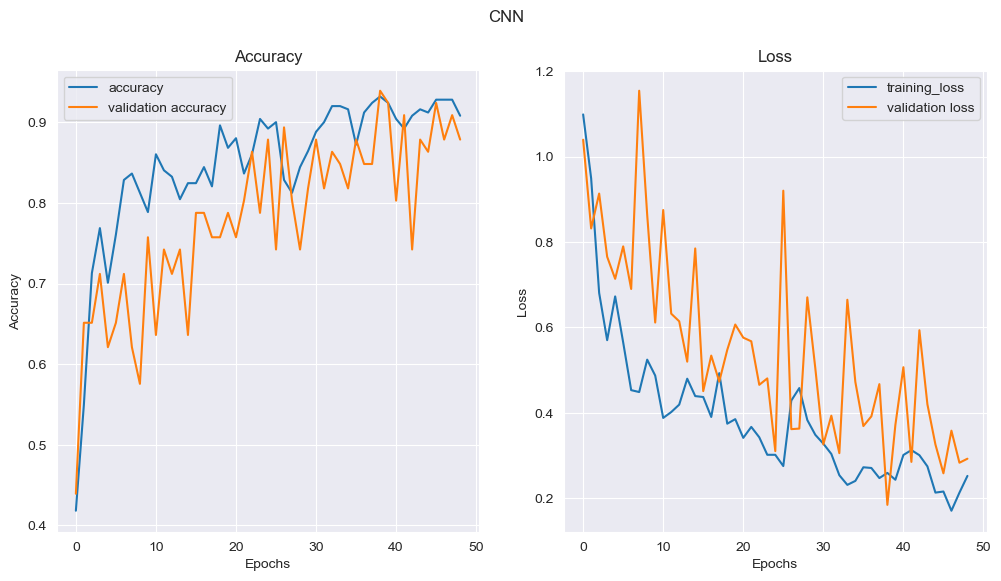

In [60]:
# Model testing
history = fit_model(model, training_data, testing_data, e=50)

In [57]:
# Evaluation:
train_eval = model.evaluate(training_data)
test_eval = model.evaluate(testing_data)

print(f'Training Set: Loss:{train_eval[0]}, Accuracy:{train_eval[1]}')
print(f'Test Set: Loss:{test_eval[0]}, Accuracy:{test_eval[1]}')

3/3 [==============================] - 2s 425ms/step - loss: 0.5138 - accuracy: 0.8182
Training Set: Loss:0.30669212341308594, Accuracy:0.8884462118148804
Test Set: Loss:0.5137545466423035, Accuracy:0.8181818127632141


In [48]:
# Analysis
test_labels = []
test_features = []

for i in range(len(classes.keys())):
    test_features.append(testing_data[i][0])
    test_labels.append((testing_data[i][-1]))

test_features = np.vstack(test_features)
test_labels = np.concatenate(test_labels, axis=0)

y_test_pred_prob = model.predict(test_features)
y_test_pred = np.argmax(y_test_pred_prob,axis=1)
print(len(y_test_pred), len(test_labels))
#
conf_matrix = pd.DataFrame(confusion_matrix(test_labels, y_test_pred), index=classes.keys(), columns=classes.keys())
conf_matrix

3/3 [==============================] - 1s 243ms/step
66 66


Normal  Viral Pneumonia  Covid
Normal               15                5      0
Viral Pneumonia       3               15      2
Covid                 2                2     22

In [49]:
def show_metrics(matrix_df):
    lightblue = sns.light_palette("skyblue", as_cmap=True)
    fig,ax = plt.subplots(1,1, figsize=(5,5))
    sns.heatmap(matrix_df, 
                     annot=True,
                     vmin=0, 
                     fmt='g',
                     cmap=lightblue, 
                     cbar=False,
                     xticklabels=['Normal','Viral Penumonia','Covid'],
                     yticklabels=['Normal','Viral Penumonia','Covid'],
                     ax=ax)
    ax.set(xlabel='Predicted_labels',
           ylabel='Actual labels')
    plt.show()
    print(classification_report(test_labels,y_test_pred))
    return fig

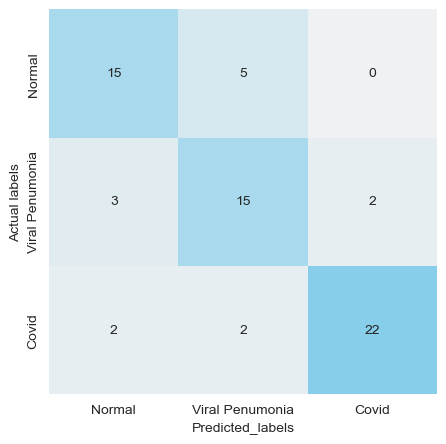

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        20
         1.0       0.68      0.75      0.71        20
         2.0       0.92      0.85      0.88        26

    accuracy                           0.79        66
   macro avg       0.78      0.78      0.78        66
weighted avg       0.79      0.79      0.79        66


In [61]:
fig = show_metrics(conf_matrix)
fig.savefig('Images/model1_conf_matrix.png')